[경고] 충돌이 발생하지 않음! 기본 점수를 적용합니다.
[제외] Angle: 0, Power: 1.0 - 목적구 전혀 못 맞힘
[제외] Angle: 0, Power: 2.0 - 목적구 전혀 못 맞힘
[제외] Angle: 0, Power: 3.0 - 목적구 전혀 못 맞힘
[제외] Angle: 0, Power: 4.0 - 목적구 전혀 못 맞힘
[제외] Angle: 0, Power: 5.0 - 목적구 전혀 못 맞힘
[제외] Angle: 0, Power: 6.0 - 목적구 전혀 못 맞힘
[제외] Angle: 0, Power: 7.0 - 목적구 전혀 못 맞힘
[제외] Angle: 0, Power: 8.0 - 목적구 전혀 못 맞힘
[제외] Angle: 0, Power: 9.0 - 목적구 전혀 못 맞힘
[제외] Angle: 0, Power: 10.0 - 목적구 전혀 못 맞힘
[경고] 충돌이 발생하지 않음! 기본 점수를 적용합니다.
[제외] Angle: 5, Power: 1.0 - 목적구 전혀 못 맞힘
[제외] Angle: 5, Power: 2.0 - 목적구 1개만 맞힘
[제외] Angle: 5, Power: 3.0 - 목적구 1개만 맞힘
[제외] Angle: 5, Power: 4.0 - 목적구 1개만 맞힘
[제외] Angle: 5, Power: 5.0 - 목적구 1개만 맞힘
[제외] Angle: 5, Power: 6.0 - 목적구 1개만 맞힘
[제외] Angle: 5, Power: 7.0 - 목적구 1개만 맞힘
[제외] Angle: 5, Power: 8.0 - 목적구 1개만 맞힘
[제외] Angle: 5, Power: 9.0 - 목적구 1개만 맞힘
[제외] Angle: 5, Power: 10.0 - 목적구 1개만 맞힘
[제외] Angle: 10, Power: 1.0 - 목적구 1개만 맞힘
[제외] Angle: 10, Power: 2.0 - 목적구 1개만 맞힘
[제외] Angle: 10, Power: 3.0 - 목적구 1개만 맞힘
[제외] Angle: 10, Power: 

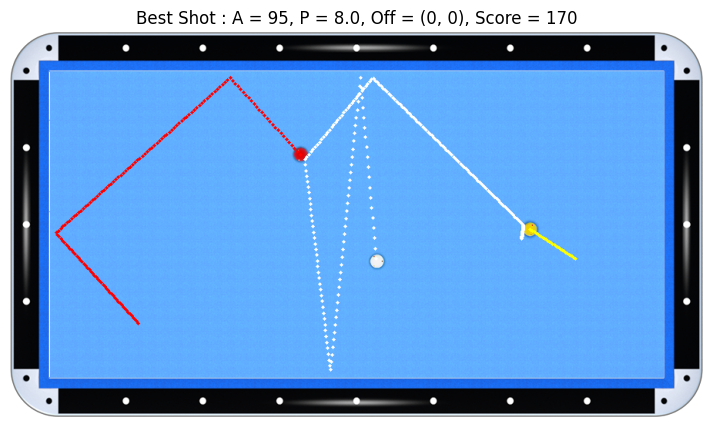

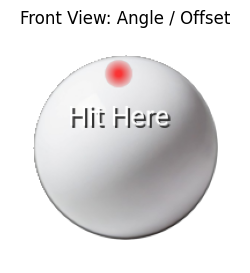

In [7]:
import cv2
import numpy as np
import pymunk
from pymunk import Vec2d
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

############################################################################
# (A) 글로벌 설정
############################################################################
cue_choice = "white_ball"  # "white_ball" 또는 "yellow_ball"
collision_log = []
frame_count = 0
last_collision_frame = -999
last_collision_type = None

# 배경 이미지 (사용자가 요청한 당구대 이미지)
background_image_path = r"C:\Aiffelthon\Q-FitProj\ModelTraining\Image&TextResult\billiard_final.png"

# 프론트 큐볼(흰색 공) 이미지 경로 (4채널 PNG)
front_ball_path = r"C:\Aiffelthon\Q-FitProj\ModelTraining\CommonData\TableSourceImage\white_cue_ball.png"

# 파워 게이지 이미지 저장 경로
gauge_image_path = r"C:\Aiffelthon\Q-FitProj\ModelTraining\CommonData\TableSourceImage\power_gauge.png"

############################################################################
# (F') 코드1에서 사용한 overlay_frame 함수 (프레임 합성용)
############################################################################
def overlay_frame(base_image, frame_image_path):
    """
    당구대 프레임을 공이 배치된 테이블 이미지 위에 합성하여 최종 출력을 반환
    - base_image: 공이 배치된 당구대 이미지 (BGR 형식)
    - frame_image_path: 프레임 이미지 경로 (BGRA 포맷, 알파 채널 포함)
    """
    # 프레임 이미지 로드 (4채널, BGRA)
    frame_image = cv2.imread(frame_image_path, cv2.IMREAD_UNCHANGED)
    if frame_image is None:
        print(f"[오류] 프레임 이미지 불러오기 실패: {frame_image_path}")
        return base_image

    # base_image를 BGRA로 변환 (알파 채널 추가)
    base_rgba = cv2.cvtColor(base_image, cv2.COLOR_BGR2BGRA)
    
    # 프레임 크기에 맞게 패딩된 BGRA 이미지 생성
    h_f, w_f = frame_image.shape[:2]
    h_b, w_b = base_image.shape[:2]
    
    x_offset = (w_f - w_b) // 2
    y_offset = (h_f - h_b) // 2
    
    # 완전 투명한 배경으로 초기화 (알파 채널 = 0)
    padded_base = np.zeros((h_f, w_f, 4), dtype=np.uint8)
    # base 이미지 복사 (알파 채널 = 255)
    padded_base[y_offset:y_offset + h_b, x_offset:x_offset + w_b] = base_rgba
    
    # 알파 채널을 활용한 블렌딩
    alpha_frame = frame_image[:, :, 3:4] / 255.0

    # 결과 이미지 생성 (BGRA)
    result = np.zeros_like(padded_base)
    
    for c in range(3):
        result[:, :, c] = (
            frame_image[:, :, c] * alpha_frame[:, :, 0] +
            padded_base[:, :, c] * (1 - alpha_frame[:, :, 0])
        ).astype(np.uint8)
    
    # 알파 채널 설정
    result[:, :, 3] = np.where(frame_image[:, :, 3] == 0,
                               padded_base[:, :, 3],
                               frame_image[:, :, 3])
    
    return result


def load_ball_position(label_text_path):
    bpos = {}
    try:
        with open(label_text_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 3:
                    bpos[parts[0]] = (int(parts[1]), int(parts[2]))
    except FileNotFoundError:
        print(f"[오류] 파일 '{label_text_path}'을 찾을 수 없음")
    except ValueError:
        print(f"[오류] 파일 형식 오류. '공이름 x y' 형태여야 함")
    return bpos

def save_power_gauge_image(power_gauge):
    """
    파워 게이지 바 이미지를 생성하고 지정된 경로(gauge_image_path)에 저장합니다.
    (지금은 사용하지 않을 수도 있음)
    """
    bar_w, bar_h = 200, 40

    # 배경을 RGBA(투명)로 생성
    image = np.zeros((bar_h, bar_w, 4), dtype=np.uint8)
    image[:, :, :] = (0, 0, 0, 0)  # 완전 투명 배경

    # PIL을 사용하여 텍스트 및 게이지 바 렌더링
    image_pil = Image.fromarray(image)
    draw = ImageDraw.Draw(image_pil)

    # 폰트 경로 (조정 필요)
    font_path = r"C:\Aiffelthon\Q-FitProj\ModelTraining\CommonData\CushionFont\Roboto-Regular.ttf"
    try:
        font = ImageFont.truetype(font_path, 20)  # Roboto-Regular.ttf 폰트 적용
    except IOError:
        print(f"[오류] 폰트 파일 찾기 실패: {font_path}")
        font = ImageFont.load_default()  # 기본 폰트 사용

    # 배경 바 (회색)
    draw.rectangle([0, 0, bar_w, bar_h], fill=(50, 50, 50, 255))

    # 파워 게이지 바 (초록색)
    fill_w = int(bar_w * (power_gauge / 10))
    draw.rectangle([0, 0, fill_w, bar_h], fill=(0, 255, 0, 255))

    # 텍스트 (TTF 서체 적용)
    text = f"POWER: {power_gauge} / 10.0"
    text_size = draw.textbbox((0, 0), text, font=font)
    text_width = text_size[2] - text_size[0]

    text_x = bar_w // 2 - text_width // 2
    text_y = bar_h // 2 - 10  # 중앙 정렬
    draw.text((text_x, text_y), text, font=font, fill=(255, 255, 255, 255))

    # 최종 이미지 변환 (투명 배경 유지)
    image = np.array(image_pil)

    success = cv2.imwrite(
        gauge_image_path, 
        cv2.cvtColor(image, cv2.COLOR_RGBA2BGRA)  # RGBA → BGRA 변환 후 저장
    )
    if success:
        print(f"[정보] 파워 게이지 이미지 저장 완료: {gauge_image_path}")
    else:
        print(f"[오류] 파워 게이지 이미지 저장 실패")
    return success

def show_power_gauge_image(power_gauge):
    """
    저장된 파워 게이지 이미지를 불러와 별도로 표시 (지금은 사용하지 않을 수도 있음)
    """
    image = cv2.imread(gauge_image_path, cv2.IMREAD_UNCHANGED)
    if image is None:
        print("[오류] 파워 게이지 이미지 불러오기 실패")
        return
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA)
    plt.figure(figsize=(5, 1))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.title("Power Gauge")
    plt.show()


############################################################################
# (B) 충돌 이벤트 로깅 + 중복 쿠션 필터
############################################################################
def collision_logger(arbiter, space, data):
    global collision_log, cue_choice
    global frame_count, last_collision_frame, last_collision_type

    shapeA, shapeB = arbiter.shapes
    ctypeA = shapeA.collision_type
    ctypeB = shapeB.collision_type

    cue_ctype = 1 if cue_choice == "white_ball" else 2
    collision_char = None

    # A가 큐볼
    if ctypeA == cue_ctype:
        if ctypeB == 99: 
            collision_char = "C"
        elif ctypeB == 3: 
            collision_char = "R"
        elif ctypeB == 1 and cue_ctype != 1: 
            collision_char = "W"
        elif ctypeB == 2 and cue_ctype != 2: 
            collision_char = "Y"

    # B가 큐볼
    elif ctypeB == cue_ctype:
        if ctypeA == 99: 
            collision_char = "C"
        elif ctypeA == 3: 
            collision_char = "R"
        elif ctypeA == 1 and cue_ctype != 1: 
            collision_char = "W"
        elif ctypeA == 2 and cue_ctype != 2: 
            collision_char = "Y"

    # 쿠션(C) 연속 충돌 필터
    if collision_char == "C":
        if last_collision_type == "C" and (frame_count - last_collision_frame) < 3:
            return True

    if collision_char is not None:
        collision_log.append(collision_char)
        last_collision_type = collision_char
        last_collision_frame = frame_count

    return True


############################################################################
# (C) 3쿠션 득점 판정 및 점수 매기기
############################################################################
def check_3cushion_score(log_list, cue_choice="white_ball"):
    if cue_choice == "white_ball":
        obj_ball = ["R", "Y"]
    else:
        obj_ball = ["R", "W"]

    cushion_count = 0
    hit_set = set()
    second_ball_hit = False

    for ch in log_list:
        if ch == "C":
            cushion_count += 1
        elif ch in obj_ball:
            if ch not in hit_set:
                hit_set.add(ch)
                if len(hit_set) == 2:
                    # 3쿠션 충족하지 않으면 득점 불가
                    if cushion_count >= 3:
                        second_ball_hit = True
                    else:
                        return False, "3쿠션 미달"

    if second_ball_hit:
        return True, "정상 득점(3쿠션)"
    else:
        if len(hit_set) == 0:
            return False, "목적구 전혀 못 맞힘"
        elif len(hit_set) == 1:
            return False, "목적구 1개만 맞힘"
        else:
            return False, "쿠션 3회 미만"

def first_collision_is_object_ball(log_list):
    for ch in log_list:
        if ch != "C":
            return True
    return False

def compute_shot_score(log_list, base_score=100):
    score = base_score
    if first_collision_is_object_ball(log_list):
        score += 80
    else:
        score -= 50

    total_collisions = len(log_list)
    score -= (total_collisions * 2)
    return score


############################################################################
# (D) 실제 시뮬레이션 (각도, 파워, 오프셋)
############################################################################
def simulate_shot(table_image, ball_position, angle_deg, power_gauge, spin_offset):
    global collision_log, frame_count
    global last_collision_frame, last_collision_type

    collision_log = []
    frame_count = 0
    last_collision_frame = -999
    last_collision_type = None

    H, W = table_image.shape[:2]
    space = pymunk.Space()
    space.gravity = (0, 0)
    space.damping = 0.99

    cb = pymunk.Body(body_type=pymunk.Body.STATIC)
    rad = 5.0
    ms = 1.0
    left, right = rad, W - rad
    top, bottom = rad, H - rad

    # 테이블 벽 생성
    segs = []
    for pt1, pt2 in [
        ((left, top),    (right, top)),
        ((left, bottom), (right, bottom)),
        ((left, top),    (left, bottom)),
        ((right, top),   (right, bottom))
    ]:
        s = pymunk.Segment(cb, pt1, pt2, 0.0)
        s.elasticity = 0.90
        s.friction = 0.05
        s.collision_type = 99
        segs.append(s)
    space.add(cb, *segs)

    # 공 추가
    bod = {}
    for ccol, (cx, cy) in ball_position.items():
        bd = pymunk.Body(ms, pymunk.moment_for_circle(ms, 0, rad))
        bd.position = (cx, cy)
        bd.angular_damping = 0.1
        sh = pymunk.Circle(bd, rad)
        sh.elasticity = 0.90
        sh.friction = 0.05
        if ccol == "white_ball":
            sh.collision_type = 1
        elif ccol == "yellow_ball":
            sh.collision_type = 2
        elif ccol == "red_ball":
            sh.collision_type = 3
        else:
            sh.collision_type = 10
        space.add(bd, sh)
        bod[ccol] = bd

    # 큐볼 선택
    cue_ctype = 1 if cue_choice == "white_ball" else 2
    cue_ball_body = bod[cue_choice]

    # 충돌 핸들러 추가
    handler_any = space.add_wildcard_collision_handler(cue_ctype)
    handler_any.post_solve = collision_logger

    dt = 1/60
    mx = 1200
    friction_factor = 0.015
    st_t = 0.3  # 정지 판정 임계값

    # 샷 힘 설정
    power_gauge = min(power_gauge, 10.0)
    if power_gauge < 0:
        power_gauge = 0

    max_sp = 200.0
    rads = np.deg2rad(angle_deg)
    dx, dy = np.cos(rads), -np.sin(rads)
    spd = (power_gauge / 10) * max_sp
    imp_vec = Vec2d(dx, dy) * (spd * ms)

    # 큐볼에 힘 적용
    offx, offy = spin_offset
    ip = cue_ball_body.position + Vec2d(offx, offy)
    cue_ball_body.apply_impulse_at_world_point(imp_vec, ip)

    traj = {c: [] for c in bod}

    # 시뮬레이션 루프
    for _ in range(mx):
        frame_count += 1
        space.step(dt)

        all_stop = True
        for ccx, bb in bod.items():
            bb.velocity *= (1 - friction_factor * dt)
            traj[ccx].append((bb.position.x, bb.position.y))
            if bb.velocity.length > st_t:
                all_stop = False

        if all_stop:
            break

    # 득점 판정
    scored, reason = check_3cushion_score(collision_log, cue_choice)

    # 충돌 로그가 비어있는 경우
    if len(collision_log) > 0:
        if collision_log[0] in ["R", "Y"]:
            shot_score = compute_shot_score(collision_log, base_score=150)
        else:
            shot_score = compute_shot_score(collision_log, base_score=100)
    else:
        print("[경고] 충돌이 발생하지 않음! 기본 점수를 적용합니다.")
        shot_score = 50

    return scored, reason, traj, collision_log, shot_score


############################################################################
# (E) 직접 경로 샷 탐색
############################################################################
def find_direct_path_shot(table_image, ball_position):
    """
    목적구를 먼저 맞추는 샷을 우선적으로 탐색하고,
    없을 경우 쿠션을 활용한 샷을 찾는다.
    """
    initial_angles = range(0, 360, 5)
    initial_powers = np.arange(1, 11, 1.0)
    initial_offsets = [(0, 0)]

    best_shots = []
    backup_shots = []

    for ang in initial_angles:
        for pwr in initial_powers:
            for off in initial_offsets:
                scored, reason, traj, clog, shot_score = simulate_shot(
                    table_image, 
                    ball_position, 
                    ang, 
                    pwr, 
                    off
                )

                # 3쿠션이 아닌 샷은 제외
                if not scored:
                    print(f"[제외] Angle: {ang}, Power: {pwr} - {reason}")
                    continue

                # 3쿠션 충족 시, best_shots에 추가
                if clog and clog[0] in ["R", "Y"]:
                    best_shots.append((shot_score, ang, pwr, off, reason, traj, clog))
                else:
                    backup_shots.append((shot_score, ang, pwr, off, reason, traj, clog))

    if best_shots:
        return max(best_shots, key=lambda x: x[0])

    if backup_shots:
        print("[새로운 탐색] 목적구를 먼저 맞춘 샷 없음. 쿠션을 활용한 샷을 시도합니다.")
        return max(backup_shots, key=lambda x: x[0])

    print("[새로운 탐색] 득점 가능한 샷 없음")
    return None


############################################################################
# (F) 테이블 위 궤적 시각화 (파워 게이지 제거)
############################################################################
def draw_trajectory_on_table(table_image, traj):
    """
    당구공의 궤적을 시각화하여 당구대 이미지 위에 표시합니다.
    (파워 게이지 표시 부분은 제거)
    """
    trajectory_image = table_image.copy()
    col_map = {"white_ball": (255, 255, 255), "yellow_ball": (0, 255, 255), "red_ball": (0, 0, 255)}
    step = 5

    for cname, points in traj.items():
        color_bgr = col_map.get(cname, (0, 255, 0))
        for i in range(0, len(points), step):
            x, y = points[i]
            cx, cy = int(x), int(y)
            cv2.circle(trajectory_image, (cx, cy), 2, color_bgr, -1)

    return trajectory_image


############################################################################
# (G) 정면에서 본 공 + 당점 표시 + "Hit Here" 텍스트 + 투명 배경
############################################################################
def show_front_hit_point(angle_deg, offset_xy):
    """
    정면에서 본 흰색 공 위에 당점(red dot)과 'Hit Here' 텍스트를 표시.
    배경은 전부 투명 처리해서 공만 보이도록 한다.
    """
    w, h = 200, 200
    center = (w // 2, h // 2)
    radius = 80

    # 1) 완전 투명 RGBA 캔버스
    front_view_image = np.zeros((h, w, 4), dtype=np.uint8)

    # 2) 흰색 공 텍스처 합성
    front_ball_texture = cv2.imread(front_ball_path, cv2.IMREAD_UNCHANGED)
    if front_ball_texture is not None:
        front_ball_texture = cv2.resize(front_ball_texture, (2*radius, 2*radius), interpolation=cv2.INTER_AREA)
        x1, y1 = center[0] - radius, center[1] - radius
        x2, y2 = center[0] + radius, center[1] + radius

        alpha_s = front_ball_texture[:, :, 3] / 255.0
        for c in range(3):
            front_view_image[y1:y2, x1:x2, c] = (
                alpha_s * front_ball_texture[:, :, c] +
                (1 - alpha_s) * front_view_image[y1:y2, x1:x2, c]
            ).astype(np.uint8)
        front_view_image[y1:y2, x1:x2, 3] = (alpha_s * 255).astype(np.uint8)

    # 3) 당점(red dot) 표시
    hit_point_path = r"C:\Aiffelthon\Q-FitProj\ModelTraining\CommonData\TableSourceImage\hit_point.png"
    hit_point_image = cv2.imread(hit_point_path, cv2.IMREAD_UNCHANGED)

    if hit_point_image is not None:
        dot_size = int(radius * 0.3)  # 공 반지름의 30%
        hit_point_image = cv2.resize(hit_point_image, (dot_size, dot_size), interpolation=cv2.INTER_AREA)

        # 각도 + 오프셋 기반 당점 좌표
        rad = np.deg2rad(angle_deg)
        dx, dy = np.cos(rad), -np.sin(rad)
        scale_offset = 0.1
        tx = int(center[0] + dx * radius * 0.8 + offset_xy[0] * scale_offset)
        ty = int(center[1] + dy * radius * 0.8 + offset_xy[1] * scale_offset)

        # 합성 좌표
        dx2, dy2 = dot_size // 2, dot_size // 2
        px1, py1 = tx - dx2, ty - dy2
        px2, py2 = tx + dx2, ty + dy2

        alpha_p = hit_point_image[:, :, 3] / 255.0
        for c in range(3):
            front_view_image[py1:py2, px1:px2, c] = (
                alpha_p * hit_point_image[:, :, c] +
                (1 - alpha_p) * front_view_image[py1:py2, px1:px2, c]
            ).astype(np.uint8)
        front_view_image[py1:py2, px1:px2, 3] = (
            alpha_p * 255 + (1 - alpha_p) * front_view_image[py1:py2, px1:px2, 3]
        ).astype(np.uint8)

    # 4) "Hit Here" 텍스트 표시 (PIL)
    #    - 당점 아래쪽에 표시해서 원 밖으로 나가지 않도록 조정
    image_pil = Image.fromarray(front_view_image)
    draw = ImageDraw.Draw(image_pil)

    # 폰트 경로 (적절히 수정)
    font_path = r"C:\Aiffelthon\Q-FitProj\ModelTraining\CommonData\CushionFont\Roboto-Regular.ttf"
    try:
        font = ImageFont.truetype(font_path, 24)
    except IOError:
        print(f"[오류] 폰트 파일 찾기 실패: {font_path}")
        font = ImageFont.load_default()

    text_str = "Hit Here"
    text_size = draw.textbbox((0, 0), text_str, font=font)
    text_w = text_size[2] - text_size[0]

    # 텍스트를 당점 아래(약간)로 배치
    text_x = tx - (text_w // 2)
    text_y = ty + (dot_size // 2) + 10  # 당점보다 10픽셀 아래

    # 검정 그림자
    shadow_offset = (2, 2)
    draw.text(
        (text_x + shadow_offset[0], text_y + shadow_offset[1]),
        text_str,
        font=font,
        fill=(50, 50, 50, 255)
    )
    # 흰색 본문
    draw.text(
        (text_x, text_y),
        text_str,
        font=font,
        fill=(255, 255, 255, 255)
    )

    # PIL → NumPy
    front_view_image = np.array(image_pil)

    # 5) 공 영역(원 범위) 밖은 투명화 (마스킹)
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.circle(mask, center, radius, 255, -1)
    alpha = front_view_image[:, :, 3]
    alpha[mask == 0] = 0
    front_view_image[:, :, 3] = alpha

    # 최종 표시
    out_rgba = cv2.cvtColor(front_view_image, cv2.COLOR_BGRA2RGBA)
    plt.figure(figsize=(3, 3))
    plt.imshow(out_rgba)
    plt.axis("off")
    plt.title("Front View: Angle / Offset")
    plt.show()

    return front_view_image


############################################################################
# (H) 메인 함수
############################################################################
def main():
    """
    1) 샷 시뮬레이션
    2) 테이블 상에서 공 궤적 표시 (프레임 합성) - 파워 게이지 제거
    3) 정면 타격 지점 (히트 포인트) - "Hit Here" 텍스트 + 투명 배경
    """
    label_text_path = r"C:\Aiffelthon\Q-FitProj\ModelTraining\Image&TextResult\billiard_label.txt"
    result_image_path = r"C:\Aiffelthon\Q-FitProj\ModelTraining\Image&TextResult\billiard_result.png"

    # 테이블 이미지 로드
    table_image = cv2.imread(result_image_path)
    ball_position = load_ball_position(label_text_path)
    
    if table_image is None:
        print(f"[오류] 테이블 이미지 불러오기 실패: {result_image_path}")
        return

    if not ball_position:
        print("[오류] 공 위치 정보가 없음")
        return

    # 최적의 샷 찾기
    result = find_direct_path_shot(table_image, ball_position)

    if result is None:
        print("득점 가능한 샷을 찾을 수 없음")
        return

    # 결과 언팩
    best_score, best_angle, best_power, best_offset, best_reason, best_traj, best_log = result

    print("\n[최종 결과]")
    print(f"점수 = {best_score}, 각도 = {best_angle}, 파워 = {best_power}, 오프셋 = {best_offset}")
    print(f"현황: {best_reason}")
    print(f"충돌 기록: {best_log}")

    # (1) 궤적 그리기 (파워 게이지 없음)
    trajectory_image = draw_trajectory_on_table(table_image, best_traj)

    # (2) 테이블 프레임 합성
    frame_path = r"C:\Aiffelthon\Q-FitProj\ModelTraining\CommonData\TableSourceImage\table_frame.png"
    overlaid_image = overlay_frame(trajectory_image, frame_path)

    # 시각화
    out_rgb = cv2.cvtColor(overlaid_image, cv2.COLOR_BGRA2RGBA)
    plt.figure(figsize=(10, 5))
    plt.imshow(out_rgb)
    plt.title(
        f"Best Shot : A = {best_angle}, "
        f"P = {best_power}, "
        f"Off = {best_offset}, "
        f"Score = {best_score}"
    )
    plt.axis("off")
    plt.show()

    # (3) 정면 타격 지점 - 투명 배경 + 'Hit Here' 표시
    show_front_hit_point(best_angle, best_offset)

    # 만약 파워 게이지 이미지를 따로 저장/표시하고 싶다면 아래 사용
    # save_power_gauge_image(best_power)
    # show_power_gauge_image(best_power)


if __name__ == "__main__":
    main()
